<h1 style="text-align: center;"><b>3.Prescriptive Analysis</b></h1>

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.simplefilter("ignore", UserWarning)

In [10]:
clean_df = pd.read_csv(r"C:\Febi\NumpyNinja\Hackathon\Python_Launch Folder\Team12_Pytesters_PythonHackathon_August25\merged_cleandata.csv")

### Find carb_intake or insulin recommendations for each patient with Type 1 Diabetes based on their glucose to carb_intake

#### Reasoning: To generate personalized carb/insulin recommendations for all patients to optimize postprandial glucose control.

In [12]:
# Shift glucose column to see the future glucose response
clean_df['next_glucose'] = clean_df.groupby('patient_id')['glucose'].shift(-1)

# Calculate glucose change
clean_df['glucose_change'] = clean_df['next_glucose'] - clean_df['glucose']

# Step 1: Define the rule
def prescribe_action(change):
    if change > 50:
        return 'Reduce Carb or Delay Insulin'
    elif change < -30:
        return 'Add Rescue Carbs'
    elif -10 <= change <= 10:
        return 'Maintain'
    else:
        return 'Monitor/Adjust'

# Step 2: Apply to dataframe
carb_effect = clean_df[(clean_df['carb_input'] > 0) & (clean_df['glucose_change'].notnull())].copy()
carb_effect['prescription'] = carb_effect['glucose_change'].apply(prescribe_action)

# Step 3: Get most common prescription per patient
final_prescription = carb_effect.groupby('patient_id')['prescription'].agg(lambda x: x.value_counts().idxmax()).reset_index()

# Rename column
final_prescription.columns = ['Patient ID', 'Final Prescription']

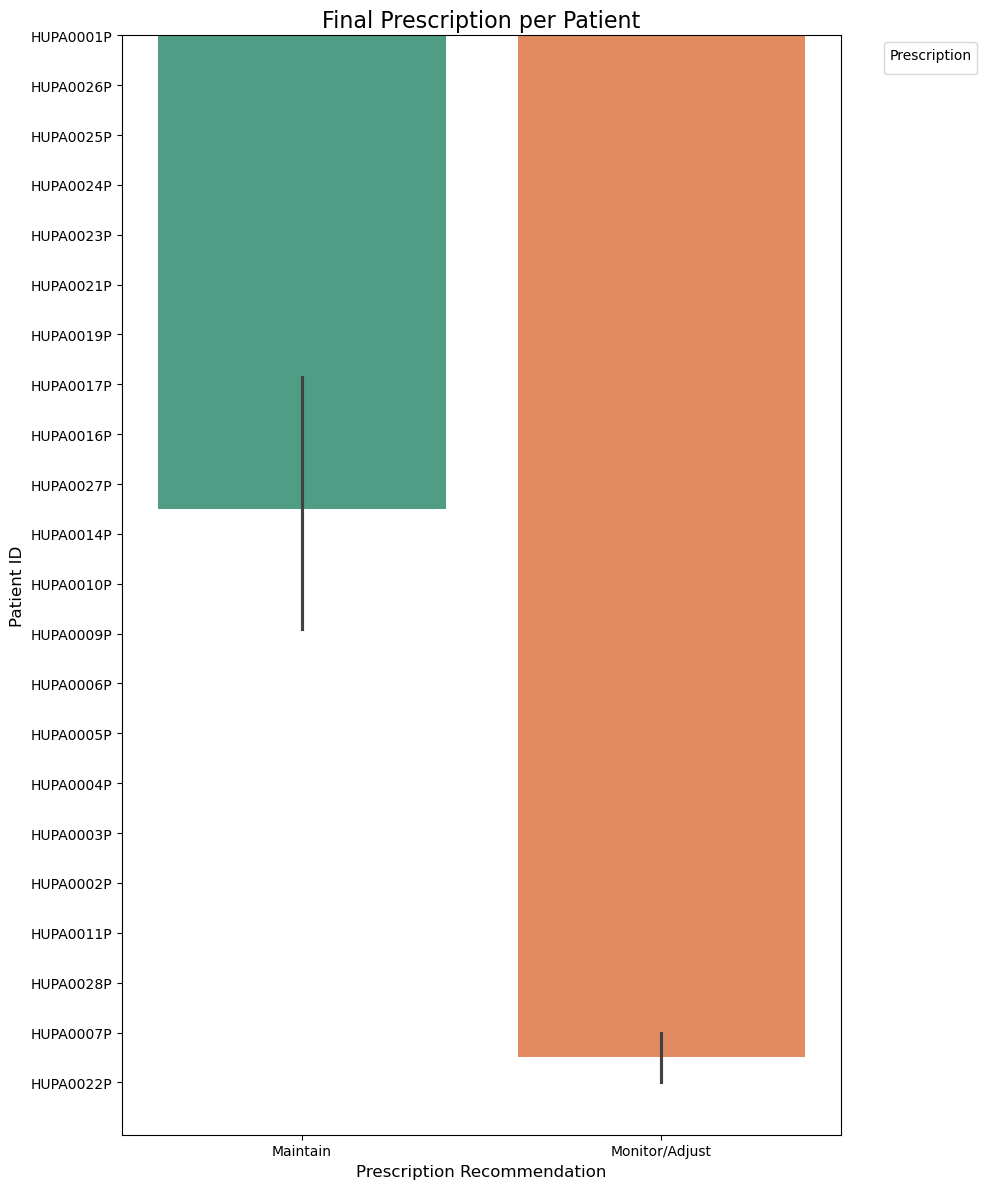

In [13]:
# Sort by prescription to group visually
final_prescription_sorted = final_prescription.sort_values('Final Prescription')

# Create color palette
palette = {
    'Reduce Carb or Delay Insulin': '#f94144',
    'Add Rescue Carbs': '#277da1',
    'Maintain': '#43aa8b',
    'Monitor/Adjust': '#f9844a'
}

# Plot
plt.figure(figsize=(10, 12))
sns.barplot(
    data=final_prescription_sorted,
    y='Patient ID',
    x='Final Prescription',
    palette=palette,
    hue='Final Prescription',
    dodge=False
)

plt.title("Final Prescription per Patient", fontsize=16)
plt.xlabel("Prescription Recommendation", fontsize=12)
plt.ylabel("Patient ID", fontsize=12)
plt.legend(title="Prescription", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()